# refer&explain 

object: 

1. Normal regularity and periodicity highlight the data without alter; non-periodical ones should alter.
2. Long-term dependence
 
data:
 1. pre 250 -> predict next 10

this try:
 1. seq2seq + attention

In [1]:
import os,sys,json,yaml,time,logging

import numpy as np
import pandas as pd

from datetime import datetime as dt

from tensorflow.keras.models import Sequential, load_model,Model
from tensorflow.keras.callbacks import History, EarlyStopping, Callback
from tensorflow.keras.layers import *
# Dense, Activation, Dropout, LSTM,GRU,RepeatVector,TimeDistributed,Concatenate,Dot,Input
import tensorflow as tf
from tensorflow.keras.activations import tanh, softmax


import matplotlib
# matplotlib.use('TkAgg')
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import psutil


# utilites 

In [2]:
def plot_entity(df, title, show_flg=False):
    """
    plot the whole entity metrics
    :param df:
    :param col_cnt:
    :return:
    """
    metric_cnt = df.shape[1]
    df.index = pd.to_datetime(df.index, unit='s')

    col_cnt = int(np.sqrt(metric_cnt)) + 2

    row_cnt = int(np.ceil(metric_cnt / col_cnt))

    metric_lst = list(df.columns)

    anom_flg = True if 'anom' in metric_lst else False
    # anom_flg = False

    # plot metrics
    fig = plt.figure(figsize=[60, 15])
    matplotlib.rcParams.update({"font.size": 7})

    SUBPLOT_IDX = 1
    for metric_name in metric_lst:
        if metric_name == 'anom':
            continue
        ax = fig.add_subplot(row_cnt, col_cnt, SUBPLOT_IDX)
        ax.plot(df.index, df[metric_name].values, color='blue')
        if anom_flg:
            val_lst = [np.nan if np.isnan(anom) else val for val, anom in
                       zip(df[metric_name].values, df["anom"].values)]
            ax.plot(df.index, val_lst, marker='o', linestyle='dashed', color='red')

        ax.set_title(metric_name)
        SUBPLOT_IDX += 1

    fig.tight_layout()
    title = f"./{title.replace('.npy','').replace('.csv','').replace('.txt','')}.png"
    
    if show_flg:
        plt.title(title)
        plt.show()
        
    
    plt.close()

    return row_cnt

def plot_pre_true(raw_df,hat_df = None,save = True):
    metric_cnt = raw_df.shape[1]
    if hat_df is not None: diff = raw_df.shape[0] - hat_df.shape[0]
    
    col_cnt = int(np.sqrt(metric_cnt)) + 2

    row_cnt = int(np.ceil(metric_cnt / col_cnt))


    # anom_flg = True if 'anom' in metric_lst else False
    anom_flg = False

    # plot metrics
    fig = plt.figure(figsize=[80, 20])
    matplotlib.rcParams.update({"font.size": 7})

    SUBPLOT_IDX = 1
    for metric_name in range(metric_cnt):
        if metric_name == 'anom':
            continaue
        ax = fig.add_subplot(row_cnt, col_cnt, SUBPLOT_IDX)
        ax.plot(raw_df[:,metric_name], color='blue')
        if hat_df is not None:
            predict = [np.nan for _ in range(diff)]
            
            predict.extend(hat_df[:,metric_name])
            print(predict)
            ax.plot(predict, color='red')
        if anom_flg:
            val_lst = [np.nan if np.isnan(anom) else val for val, anom in
                       zip(raw_df[metric_name].values, raw_df["anom"].values)]
            ax.plot(raw_df.index, val_lst, marker='o', linestyle='dashed', color='red')

        ax.set_title(metric_name)
        SUBPLOT_IDX += 1

    fig.tight_layout()
    # plt.show()
    # file_name = f"./{file_name.replace('.npy','').replace('.csv','').replace('.txt','')}.png"
    if save: plt.savefig('./data/%s/plot.png'%detector.id)
    plt.show()

# injection to original data

Principle: 

In order to facilitate observation, carry out positive interference to periodic data; carry out abnormal interference non-periodically

# dataSet_sin

In [89]:
def generate_data(show=False):
    def sine_data(ts_len=172800, period=2880, amplitude=1, noise_df=10, seed=0):
        """
        Simulation data： Default 172800(4 * 30 * 1440), 4 month data.
        """
        np.random.seed(seed)
        one_period_ary = np.abs(amplitude * (np.sin(np.linspace(0, 2*np.pi, period))))
        pcnt = int(ts_len / one_period_ary.shape[0])
        base_ary = np.tile(one_period_ary, pcnt)
        noise = np.random.standard_t(df=noise_df, size=base_ary.shape[0]) # T distribution generate random data
        base_ary = base_ary + noise

        return base_ary

    ts_len = 1440 * 28 * 4
    metric_cnt = 7
    # generate data with different period,freq
    metric_1_ary = sine_data(ts_len=ts_len, period=2880, amplitude=5, noise_df=10, seed=1)
    metric_2_ary = sine_data(ts_len=ts_len, period=1440, amplitude=50, noise_df=3, seed=2)
    metric_3_ary = sine_data(ts_len=ts_len, period=5760, amplitude=200, noise_df=2, seed=3)
    metric_4_ary = sine_data(ts_len=ts_len, period=2880, amplitude=10, noise_df=5, seed=4)
    metric_5_ary = sine_data(ts_len=ts_len, period=2880, amplitude=2, noise_df=10, seed=5)
    np.random.seed(6)
    metric_6_ary = np.random.standard_t(df=5, size=ts_len)
    metric_7_ary = np.random.exponential(scale=10, size=ts_len)
    if show:
        fig, axs = plt.subplots(metric_cnt, figsize=(15, metric_cnt*2))
        fig.suptitle('Subplots')
        axs[0].plot(range(metric_1_ary.shape[0]), metric_1_ary,'tab:blue')
        axs[1].plot(range(metric_1_ary.shape[0]), metric_2_ary,'tab:blue')
        axs[2].plot(range(metric_1_ary.shape[0]), metric_3_ary,'tab:blue')
        axs[3].plot(range(metric_1_ary.shape[0]), metric_4_ary,'tab:blue')
        axs[4].plot(range(metric_1_ary.shape[0]), metric_5_ary,'tab:blue')
        axs[5].plot(range(metric_1_ary.shape[0]), metric_6_ary,'tab:blue')
        axs[6].plot(range(metric_1_ary.shape[0]), metric_7_ary,'tab:blue')

        plt.show()
    # step0. construct entity
    start_tm = 1577808000
    end_tm = start_tm + 60 * metric_1_ary.shape[0] - 60
    # tm_idx = pd.to_datetime(np.linspace(start_tm, end_tm, metric_1_ary.shape[0]), unit='s')
    tm_idx = np.linspace(start_tm, end_tm, metric_1_ary.shape[0]) # 2019-12-31 16:00:00 -> 2020-04-21 15:59:00

    raw_df = pd.DataFrame({
        "m1": metric_1_ary,
        "m2": metric_2_ary,
        "m3": metric_3_ary,
        "m4": metric_4_ary,
        "m5": metric_5_ary,
        "m6": metric_6_ary,
        "m7": metric_7_ary
    }, index = tm_idx)

    column_lst = raw_df.columns

    # step1. weekly big pattern
    tmp_ary = raw_df.values

    for idx in range(1000, 1010):
        tmp_ary[idx::7*1440] = np.abs(tmp_ary[idx::7*1440] + np.mean(tmp_ary, axis = 0) * 5)

    rgl_df = pd.DataFrame(tmp_ary, columns=column_lst, index=tm_idx)
    # print(rgl_df.shape)
    # plot_entity(df=rgl_df, title="raw", show_flg=True)

    # step2. unregular pattern
    start_idx_lst = [int(rgl_df.shape[0] * (1/6)),
                    int(rgl_df.shape[0] * (3/7)),
                    int(rgl_df.shape[0] * (5/14)),
                    int(rgl_df.shape[0] * (8/15)),
                    int(rgl_df.shape[0] * (5/6)),
                    int(rgl_df.shape[0] * (6/7)),
                    int(rgl_df.shape[0] * (13/14))]

    # print(start_idx_lst)

    tmp_ary = rgl_df.values
    for start in start_idx_lst:
        for idx in range(start, start+10):
            tmp_ary[idx] = tmp_ary[idx] - np.mean(tmp_ary, axis = 0) * 3

    df = pd.DataFrame(tmp_ary, columns=column_lst, index=tm_idx)
    print(df.shape)
    if show: 
        plot_entity(df, 'original data',True)
        # part data
        plot_entity(df.iloc[:5000,:],'part data',True)
    if not show:
        df.index = pd.to_datetime(df.index, unit='s')
    return df


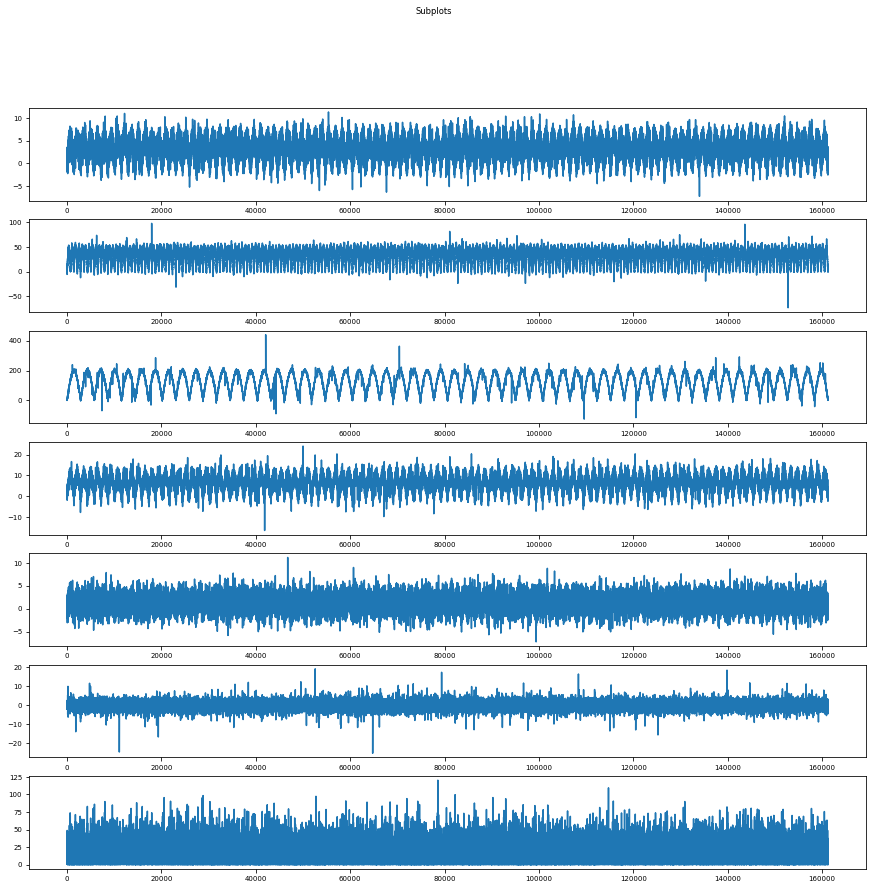

(161280, 7)


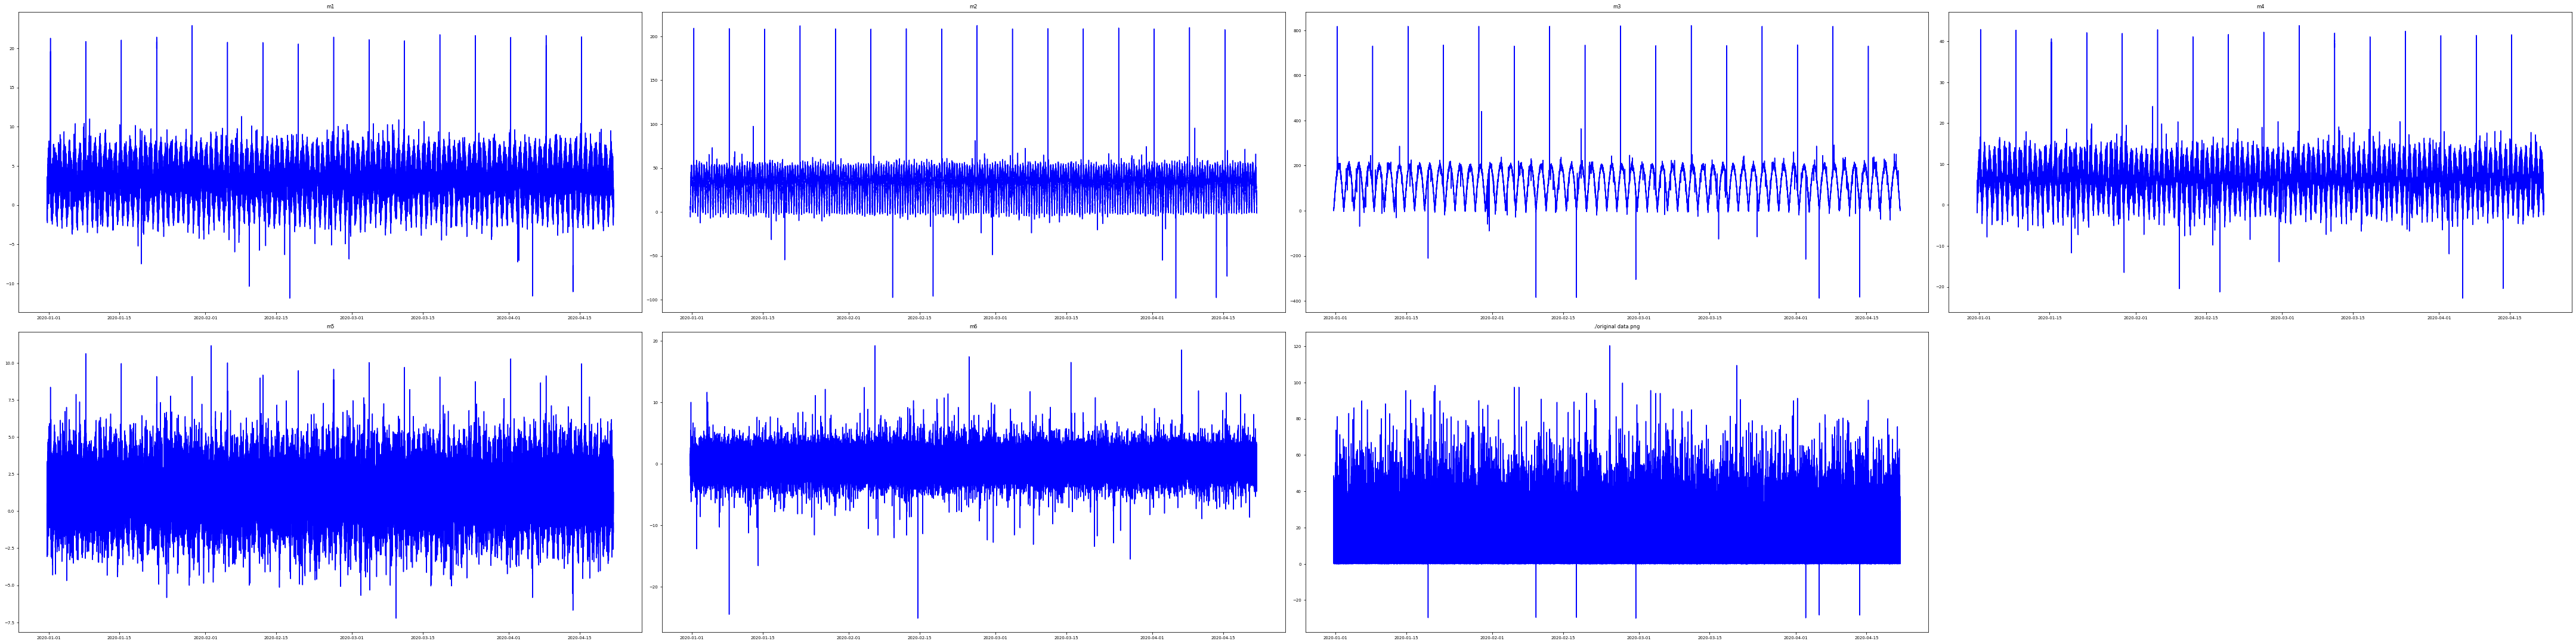

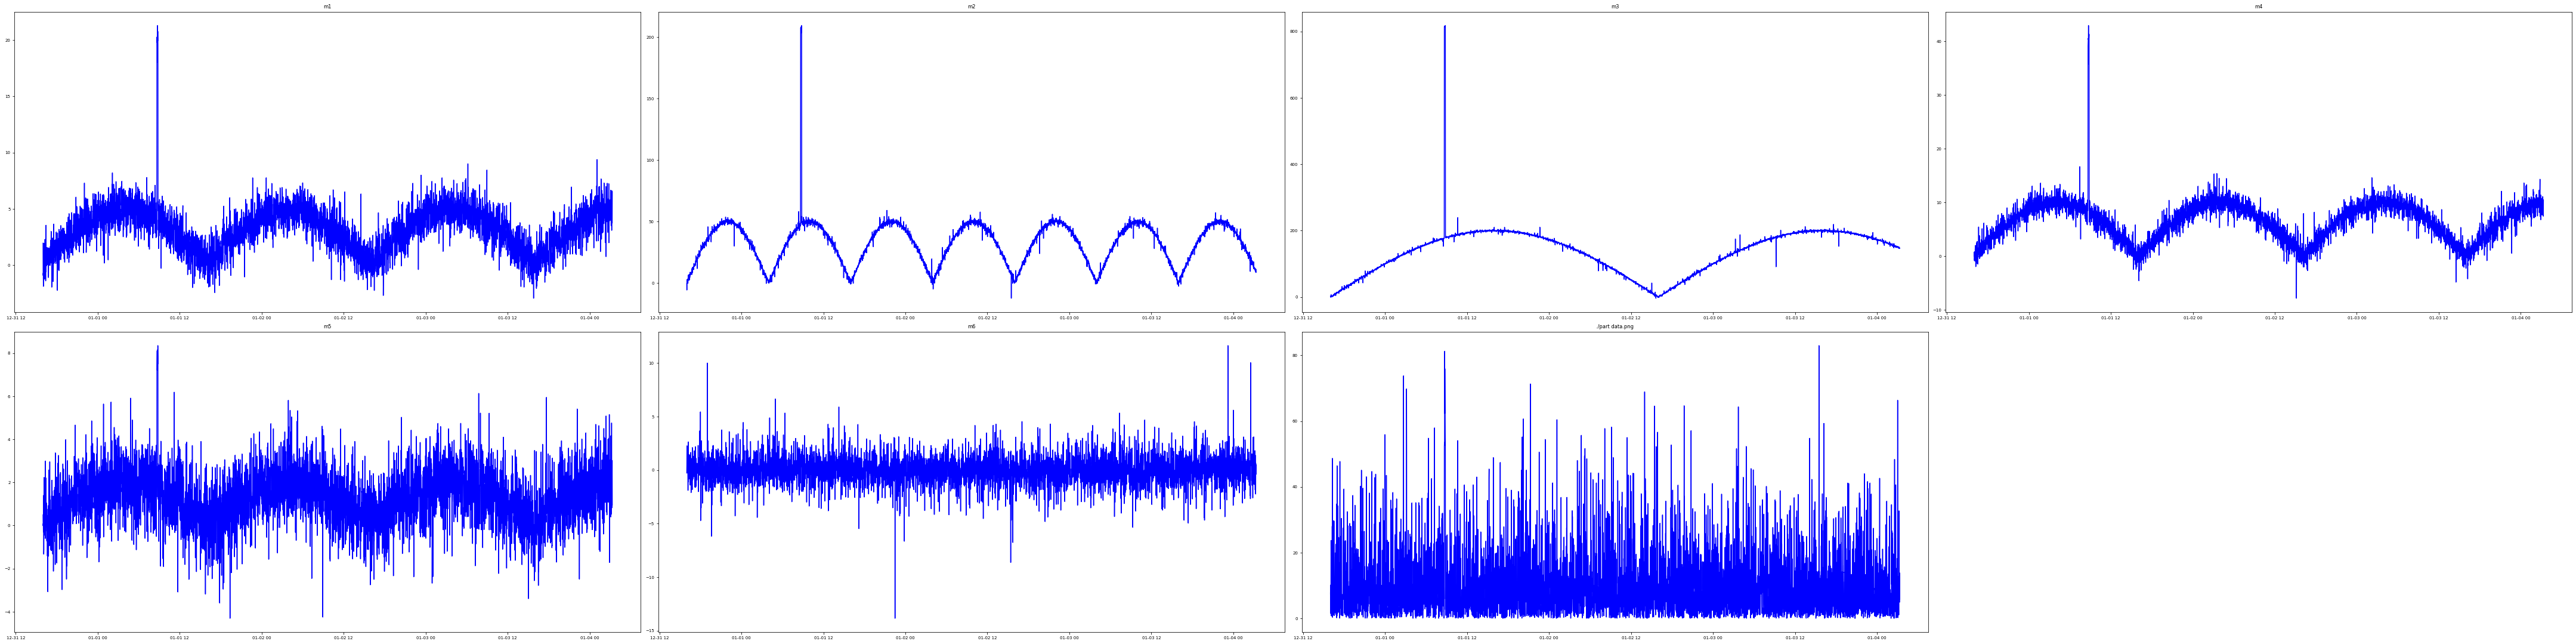

In [64]:
# complete figure
df = generate_data(show=True)

In [71]:
# narry = np.asarray(df, dtype=np.float32)
train_df = df[:'2020-03-21 00:00:00']
test_df = df['2020-03-21 00:00:00':]
train_arr = np.asarray(df, dtype=np.float32)
test_arr = np.asarray(df, dtype=np.float32)

In [91]:
df = generate_data()
train_df = df[:'2020-03-21 00:00:00']
test_df = df['2020-03-21 00:00:00':]
train = np.asarray(train_df, dtype=np.float32)
test = np.asarray(test_df, dtype=np.float32)

(161280, 7)


# data split 

In [142]:
class Channel:
    def __init__(self,config):
        """
        Load and reshape channel values (predicted and actual).

        Args:

        Attributes:

            X_train (arr): training inputs with dimensions
                [timesteps, l_s, input dimensions)
            X_test (arr): test inputs with dimensions
                [timesteps, l_s, input dimensions)
            y_train (arr): actual channel training values with dimensions
                [timesteps, n_predictions, 1)
            y_test (arr): actual channel test values with dimensions
                [timesteps, n_predictions, 1)
            train (arr): train data loaded from .npy file
            test(arr): test data loaded from .npy file
        """
        self.config = config
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.y_hat = None
        self.train = None
        self.test = None
        
    def shape_data(self, arr, train = True, reshapor = False):
        """Shape raw input streams for ingestion into LSTM. config.l_s specifies
        the sequence length of prior timesteps fed into the model at
        each timestep t.

        Args:
            arr (np array): array of input streams with
                dimensions [timesteps, 1, input dimensions]
            train (bool): If shaping training data, this indicates
                data can be shuffled
        """
        data = [] # batch * (n_prediction+l_s) * dim
        for i in range(len(arr) - self.config.l_s - self.config.n_predictions):
            data.append(arr[i:i + self.config.l_s + self.config.n_predictions])
        data = np.array(data)

        assert len(data.shape) == 3
        
        if train:
            np.random.shuffle(data)
            self.X_train = data[:, :-self.config.n_predictions, :]
            self.y_train = data[:, -self.config.n_predictions:, :]
            if reshapor:
                self.y_train = self.y_train.reshape((-1, self.config.n_predictions * self.test.shape[-1]))
        else:
            self.X_test = data[:, :-self.config.n_predictions, :]
            self.y_test = data[:, -self.config.n_predictions:, :] # [batch,test_n,metric_n]
            if reshapor:
                self.y_test = self.y_test.reshape((-1, self.config.n_predictions * self.test.shape[-1]))
    
    def preprocess(self, df):
        df = df.interpolate(method='linear', axis=0, limit_direction=None)
        index = df.index
        nary = np.asarray(df, dtype=np.float32)
        df_nary = np.nan_to_num(nary) # some col's nan is to much, can't be interplote
        df_nary_norm = MinMaxScaler().fit_transform(df_nary)
        return df_nary_norm

    def inject_anoma(self,data):
        
        # 30min each week
        tmp_time = pd.date_range("2020-05-01 16:01:00", "2020-10-01 00:00:00", freq='w')
        need_time = pd.date_range("2020-05-01 16:00:00", "2020-10-01 00:00:00", freq='w')

        for each_time in tmp_time:
            need_time = need_time.append(pd.date_range(each_time,periods=29,freq='min'))
            
        week_change_df = np.abs(data.loc[need_time,:].add(df.mean() * 5))

        data.loc[need_time,:] = week_change_df
        
        # random time
        random_index = np.random.randint(low = 0, high =len(data),size = (len(tmp_time)//5,)).tolist()
        for i in random_index:
            data.iloc[i:i+20,:] = data.iloc[i:i+20,:].sub(data.mean() * 2)
        
       
        return data
    
    def load_data(self):
        """
        Load train and test data from local.
        """
        try:
            if self.config.file_name == 'Cassini':
                inject = False
                data_path = os.path.join(self.config.dataset_root_path, self.config.file_name, self.config.data_file_name+".csv")
                df = pd.read_csv(data_path, index_col=0)
                df.index = pd.to_datetime(df.index, unit='s')

                if inject:
                    df = self.inject_anoma(df)
                train_df = df[:"2020-08-01 00:00:00"]                
                test_df = df["2020-08-01 00:00:00":]
                
                self.train = self.preprocess(train_df)
                self.test = self.preprocess(test_df) 
                
            else:
                df = generate_data()
                train_df = df[:'2020-03-21 00:00:00']
                test_df = df['2020-03-21 00:00:00':]
                self.train = np.asarray(train_df, dtype=np.float32)
                self.test = np.asarray(test_df, dtype=np.float32)
                
            print(f"load datasets self.train: {self.train.shape}, {self.train.dtype}")
            print(f"load datasets self.test: {self.test.shape}, {self.test.dtype}")
        except FileNotFoundError as e:
            print(e)
            print("Source data not found, may need to add data to repo: <link>") 
            
            
        if 'lstm' in self.config.method:
            self.shape_data(self.train,reshapor=True)
            self.shape_data(self.test, train=False,reshapor=True)
        else:
            self.shape_data(self.train)
            self.shape_data(self.test, train=False)

        print(f"self.X_train: {self.X_train.shape}")
        print(f"self.y_train: {self.y_train.shape}")
        print(f"self.X_test: {self.X_test.shape}")
        print(f"self.y_test: {self.y_test.shape}")

# seq2seq 

In [93]:
class AttentionSeq2Seq:
    def __init__(self,n_prediction,l_s,dim,hidden_size):
        self.n_prediction = n_prediction
        self.l_s = l_s
        self.dim = dim
        self.hidden_size = hidden_size
        self.Attention = None
        self.get_attention()
        
    def get_attention(self):
        """
        define Attention
        :return: attention structure
        """
        repeator = RepeatVector(self.l_s)
        concatenator = Concatenate(axis=-1)
        densor1 = Dense(32, activation="tanh", use_bias = False ,name='Dense1')
        densor2 = Dense(1, activation="relu", name='Dense2')
        activator = Activation(softmax,name='attention_weights')
        dotor = Dot(axes=1)
        reshapor = Reshape((1, self.dim))
        self.attention = {
            "repeator": repeator,
            "concatenator": concatenator,
            "densor1": densor1,
            "densor2": densor2,
            "activator": activator,
            "dotor": dotor,
            "Reshapor": reshapor
        }

    def computer_one_attention(self, a, s_prev):
        """
        define's attention calculate alpha and a
        :param a: (batch_size, Tx, hidden_size)
        :param s_prev: (batch_size, batch_size)
        :return: context
        """
        s_prev = self.attention["repeator"](s_prev)
        concat = self.attention["concatenator"]([a, s_prev])
        e = self.attention["densor1"](concat)
        energies = self.attention["densor2"](e)
        alphas = self.attention["activator"](energies)
        context = self.attention["dotor"]([alphas, a])
        return context
    
        
    def load_model(self):
        main_input = Input(shape=(self.l_s,self.dim), name='main_input')
        s0 = Input(shape=(self.hidden_size,), name='s0')
        c0 = Input(shape=(self.hidden_size,), name='c0')
        out0 = Input(shape=(self.dim,), name='out0')
        
        s = s0
        c = c0
        out = out0

        outputs = []

        encoder = LSTM(self.hidden_size,return_sequences = True, name="encoder")(main_input) #self.encoder(X)
        # encoder: (sample,Tx,hidden_size)
        # s: (sample,Ty)
        
        for t in range(self.n_prediction):
            context = self.computer_one_attention(encoder, s)
            context = Concatenate(axis=-1)([context,self.attention['Reshapor'](out)])
            s, _, c = LSTM(self.hidden_size, return_state=True)(context, initial_state=[s, c])
            #self.decoder(context, initial_state=[s, c])

            out = Dense(self.dim)(s)
#             out = Dense(self.dim,activation='softmax')(s)
            outputs.append(out)
        outputs = tf.stack(outputs)
        outputs = tf.transpose(outputs,[1,0,2])

        model = Model(inputs=(main_input, s0, c0,out0), outputs=outputs)
        return model


# simply:AE

In [94]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

# model 

In [134]:
class MyModel:
    def __init__(self, config, channel): # config:parm ;channel:data 
        """
        Loads/trains RNN and predicts future telemetry values for a channel.

        Args:
            config (obj): Config object containing parameters for processing
                and model training
            
            channel (obj): Channel class object containing train/test data
                for X,y for a single channel

        Attributes:
            config (obj): see Args
            
            y_hat (arr): predicted channel values
            model (obj): trained RNN model for predicting channel values
        """

        self.config = config
        self.y_hat = []
        self.model = None
        self.dim = channel.X_test.shape[-1]
        self.path = os.path.join(config.dataset_root_path,config.file_name,config.method)
        make_dirs(self.path)
        
        if not self.config.train:
            try:
                self.load()
            except FileNotFoundError:
                path = os.path.join(self.config.dataset_root_path, self.config.file_name, 'models',self.data_name +'.h5')
                logger.warning('Training new model, couldn\'t find existing model at {}'.format(path))
                self.train_seq2seqAtt(channel)
                self.save()
        else:
            if 'lstm' in self.config.method:
                self.train_lstm(channel)
            else:
                self.train_seq2seqAtt(channel)
            self.save()
            
    def train_lstm(self, channel):
        """
        Train LSTM model according to specifications in config.yaml.

        Args:
            channel (obj): Channel class object containing train/test data
                for X,y for a single channel
        """

        cbs = [History(), EarlyStopping(monitor='val_loss',
                                        patience=self.config.patience,
                                        min_delta=self.config.min_delta,
                                        verbose=0)]

        self.model = Sequential()
        
        self.model.add(GRU(
            self.config.hidden_size,
            input_shape=(channel.X_train.shape[1], channel.X_train.shape[2]),
            return_sequences=True,
        ))
        
        self.model.add(Dropout(self.config.dropout))

        self.model.add(GRU(
            self.config.hidden_size,
            input_shape=(channel.X_train.shape[1], channel.X_train.shape[2]),
            return_sequences=False))
        
        self.model.add(Dropout(self.config.dropout))

        # Fully connected
        self.model.add(Dense(
            self.config.n_predictions*self.dim))
        self.model.add(Activation('linear'))

        self.model.compile(loss='mse',
                           optimizer='adam')

        print("=====> Show models")
        print(self.model.summary())
        
        history = self.model.fit(x=channel.X_train,
                       y=channel.y_train,
                       batch_size=self.config.batch_size,
                       epochs=self.config.epochs,
                       validation_split=self.config.validation_split,
                       callbacks=cbs,
                       verbose=True,
                       use_multiprocessing = True,
                       workers = 3)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()
    def train_seq2seqAtt(self, channel):
        
        
        cbs = [History(), EarlyStopping(monitor='val_loss',
                                        patience=self.config.patience,
                                        min_delta=self.config.min_delta,
                                        verbose=0)]

        self.model = AttentionSeq2Seq(self.config.n_predictions, self.config.l_s, self.dim, self.config.hidden_size)
        self.model = self.model.load_model()
        print(self.model.summary())
        self.model.compile(optimizer='adam',
                      loss='mse',
                      metrics=['accuracy'])

        s0 = tf.zeros((channel.X_train.shape[0], self.config.hidden_size))
        c0 = tf.zeros((channel.X_train.shape[0], self.config.hidden_size))
        out0 = tf.zeros((channel.X_train.shape[0], self.dim))
        history = self.model.fit(x=[channel.X_train,s0, c0, out0],
                       y=channel.y_train,
                       batch_size=self.config.batch_size,
                       epochs=self.config.epochs,
                       validation_split=self.config.validation_split,
                       callbacks=cbs,
                       verbose=True,
                       use_multiprocessing = True,
                       workers = 3)
        
        print(history.history)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()
        
    def load(self):
        """
        Load model for channel.
        """

        logger.info('Loading pre-trained model')
        self.model = load_model(
            os.path.join(self.path, 'models', self.data_name + '.h5'))

    def save(self):
        """
        Save trained model.
        """
#         self.model.save_weights(os.path.join(self.config.dataset_root_path, self.run_id, 'models', '{}.h5'.format(self.chan_id)))
        self.model.save(
            os.path.join(self.path, 'models', '{}.h5'.format(self.config.data_file_name)))

    def aggregate_predictions(self, y_hat_batch, method='first'):
        """
        Aggregates predictions for each timestep. When predicting n steps
        ahead where n > 1, will end up with multiple predictions for a
        timestep.

        Args:
            y_hat_batch (arr): predictions shape (<batch length>, <n_preds*dim)
            method (string): indicates how to aggregate for a timestep - "first"
                or "mean"
        """

        agg_y_hat_batch = [] 
        y_hat_batch = y_hat_batch.reshape((y_hat_batch.shape[0],self.config.n_predictions,self.dim)) #(70,10,26))
        for t in range(len(y_hat_batch)):

            start_idx = t - self.config.n_predictions
            start_idx = start_idx if start_idx >= 0 else 0

            # predictions pertaining to a specific timestep lie along diagonal
            y_hat_t = np.flipud(y_hat_batch[start_idx:t + 1]).diagonal() #should be 10 * 26
            
            if method == 'first':
                agg_y_hat_batch.append(y_hat_t[:,0])
            elif method == 'mean':
                agg_y_hat_batch.append(np.mean(y_hat_t[:,0]))
        
        agg_y_hat_batch = np.array(agg_y_hat_batch)#.reshape(len(agg_y_hat_batch), 1)
        self.y_hat.append(agg_y_hat_batch)
    

    def batch_predict(self, channel):
        """
        Used trained LSTM model to predict test data arriving in batches.

        Args:
            channel (obj): Channel class object containing train/test data
                for X,y for a single channel

        Returns:
            channel (obj): Channel class object with y_hat values as attribute
        """
        
        num_batches = int((channel.y_test.shape[0] - self.config.l_s) / self.config.batch_size)
        if num_batches < 0:
            raise ValueError('l_s ({}) too large for stream length {}.'
                             .format(self.config.l_s, channel.y_test.shape[0]))

        # simulate data arriving in batches, predict each batch
        for i in range(0, num_batches + 1):
            prior_idx = i * self.config.batch_size
            idx = (i + 1) * self.config.batch_size
            if i + 1 == num_batches + 1:
                # remaining values won't necessarily equal batch size
                idx = channel.y_test.shape[0]


            X_test_batch = channel.X_test[prior_idx:idx]
            if 'lstm' in self.config.method:
                y_hat_batch = self.model.predict([X_test_batch]) 
                y_hat_batch = y_hat_batch[:,:self.dim]
            else:
                s0 = tf.zeros((X_test_batch.shape[0], self.config.hidden_size))
                c0 = tf.zeros((X_test_batch.shape[0], self.config.hidden_size))
                out0 = tf.zeros((X_test_batch.shape[0], self.dim))
                y_hat_batch = self.model.predict([X_test_batch,s0,c0,out0]) 
                y_hat_batch = y_hat_batch[:,0,:]
            
            self.y_hat.append(y_hat_batch)
                
        self.y_hat = np.concatenate(self.y_hat)
        print(f"last: y_hat.shape: {len(self.y_hat),type(self.y_hat),self.y_hat.shape}")
#         assert self.y_hat.shape == channel.y_test.shape
#         self.y_hat = np.reshape(self.y_hat, (channel.y_test.shape[0], channel.dim*self.config.n_predictions)) # 展平
        # self.y_hat = np.reshape(self.y_hat, (self.y_hat.size,))
        channel.y_hat = self.y_hat
        
        y_hat_save_path = os.path.join(self.path, 'y_hat',
                                       '{}.npy'.format(self.config.data_file_name))
        np.save(y_hat_save_path, self.y_hat)

        return channel


In [135]:
import gc
gc.collect()

23930

# main 

In [145]:
class Config:
    def __init__(self):
        self.dataset_root_path = './data/'
#         self.file_name = "Cassini"
#         self.data_file_name = "cassini"
        self.file_name = "Synthetic"
        self.data_file_name = "synthetic"
        self.method = 'lstm_20'#"seq2seq_att_20"
        self.train = True
#         self.train = False
        self.predict = True
        
        self.batch_size = 70
        self.l_s = 250
        self.n_predictions = 10
        self.hidden_size = 80
        self.epochs = 20
        self.dropout = 0.3

        self.validation_split = 0.2
        
        self.patience = 10
        self.min_delta = 0.0003
        

param = Config()


In [146]:
def make_dirs(path):
    '''
    param:
    path: ./data/Cassini/{model}/
    '''
    if not os.path.exists(path):
        os.makedirs(path)
        model_file = os.path.join(path,'models')
        hat_file = os.path.join(path,'y_hat')
        os.makedirs(model_file)
        os.makedirs(hat_file)

## syn data

### lstm 

In [147]:
channel = Channel(param)
channel.load_data()


(161280, 7)
load datasets self.train: (115681, 7), float32
load datasets self.test: (45600, 7), float32
self.X_train: (115421, 250, 7)
self.y_train: (115421, 70)
self.X_test: (45340, 250, 7)
self.y_test: (45340, 70)


In [148]:
model = MyModel(param,channel)

=====> Show models
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, 250, 80)           21360     
_________________________________________________________________
dropout_12 (Dropout)         (None, 250, 80)           0         
_________________________________________________________________
gru_13 (GRU)                 (None, 80)                38880     
_________________________________________________________________
dropout_13 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 70)                5670      
_________________________________________________________________
activation_5 (Activation)    (None, 70)                0         
Total params: 65,910
Trainable params: 65,910
Non-trainable params: 0
_______________________________

In [149]:
channel = model.batch_predict(channel)

last: y_hat.shape: (45340, <class 'numpy.ndarray'>, (45340, 7))


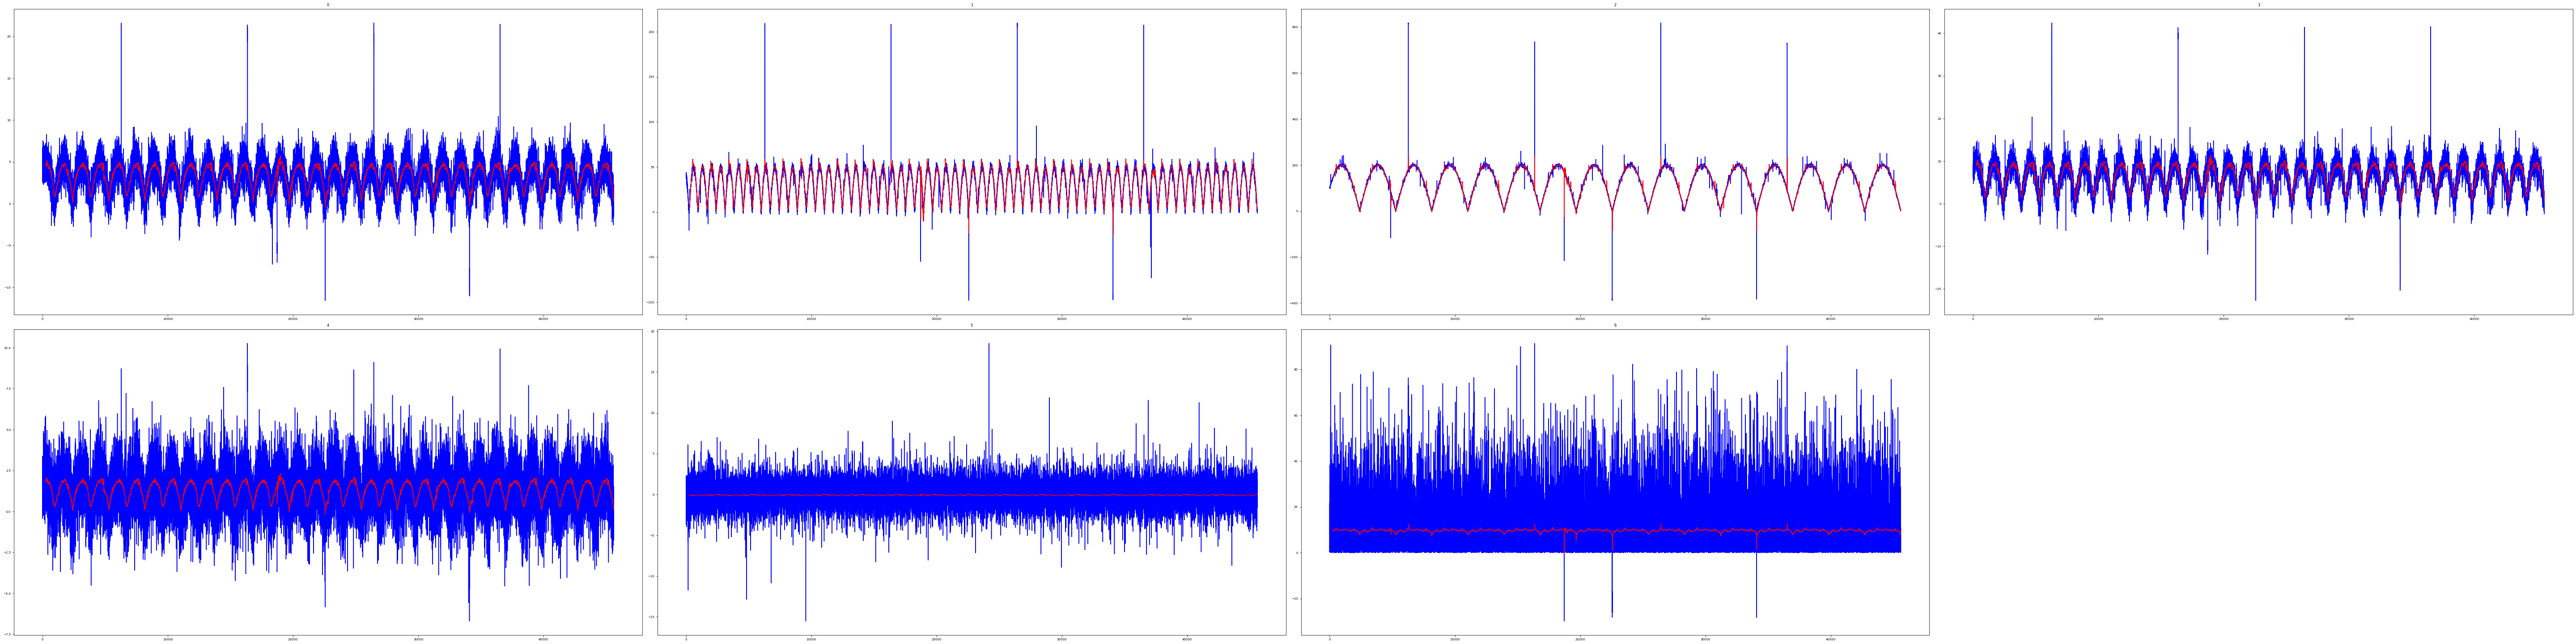

In [150]:
raw_df = channel.test
hat_df = channel.y_hat
plot_pre_true(raw_df,hat_df)

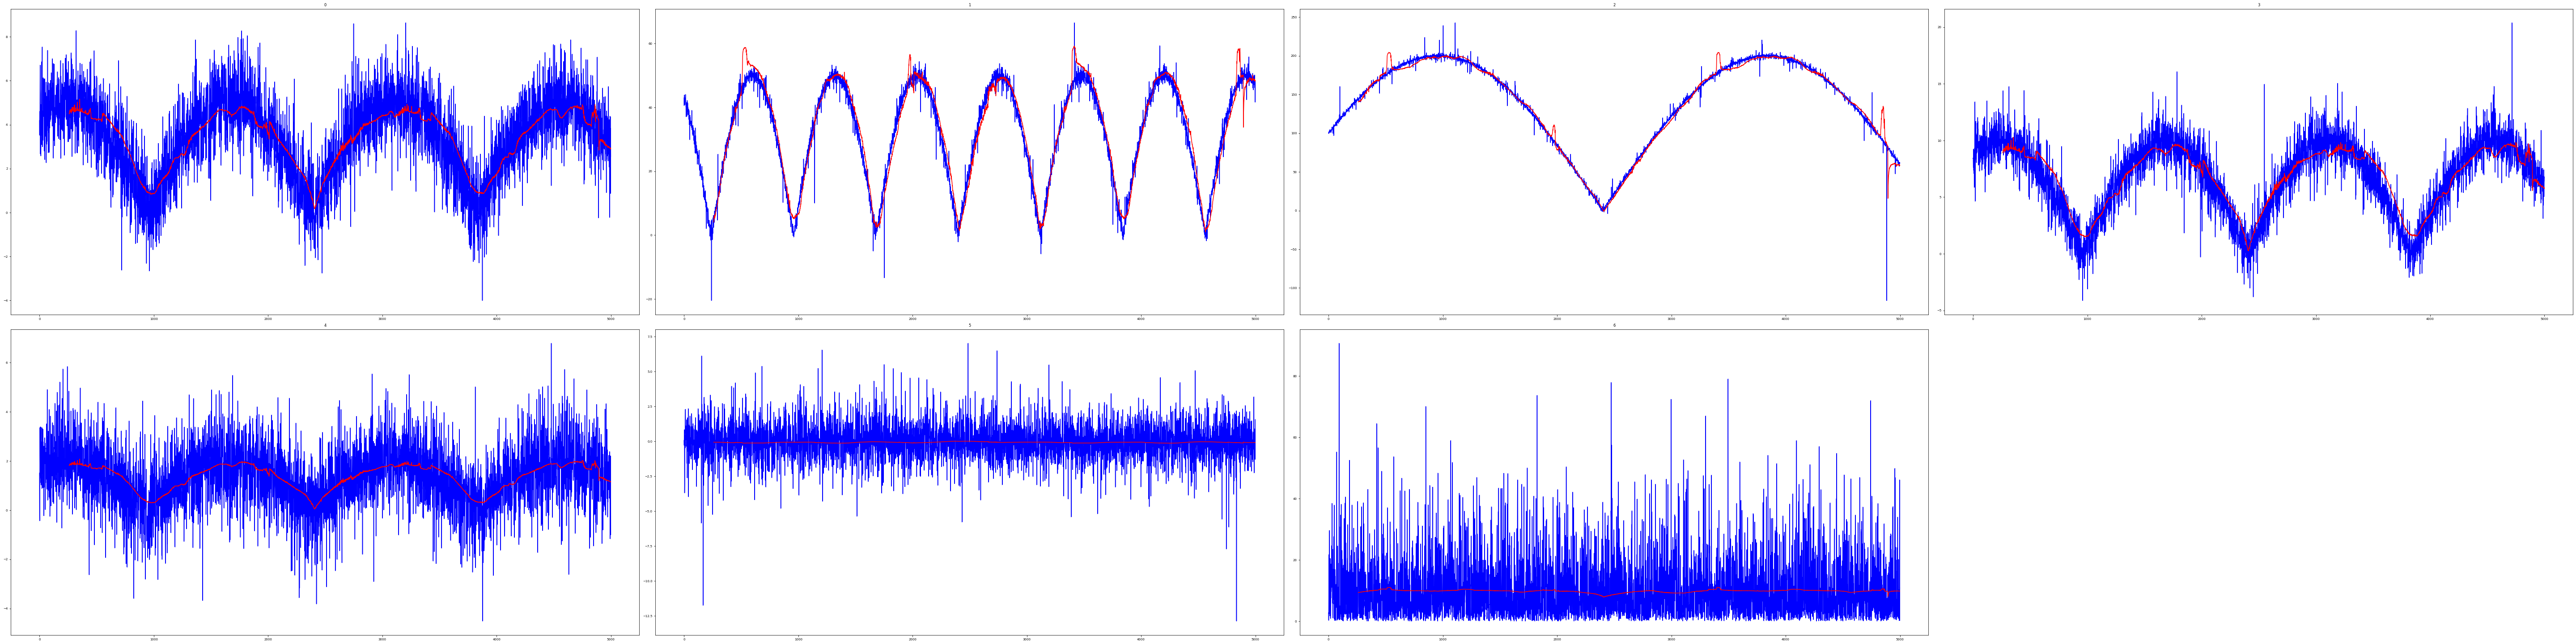

In [151]:
num = 5000
diff = raw_df.shape[0] - hat_df.shape[0]
raw = raw_df[:num,:]
d = num-diff
assert d >= 0
hat = hat_df[:d,:]
raw.shape,hat.shape
plot_pre_true(raw,hat)

###  seq2seq+att

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 250, 7)]     0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 80)]         0                                            
__________________________________________________________________________________________________
encoder (LSTM)                  (None, 250, 80)      28160       main_input[0][0]                 
__________________________________________________________________________________________________
repeat_vector_6 (RepeatVector)  (None, 250, 80)      0           s0[0][0]                         
                                                                 lstm_60[0][0]        

Epoch 1/20
1320/1320 [==============================] - 47s 35ms/step - loss: 1987.7418 - accuracy: 0.9361 - val_loss: 1204.6954 - val_accuracy: 0.9407
Epoch 2/20
1320/1320 [==============================] - 44s 33ms/step - loss: 801.1279 - accuracy: 0.9387 - val_loss: 462.4325 - val_accuracy: 0.9366
Epoch 3/20
1320/1320 [==============================] - 43s 33ms/step - loss: 321.7157 - accuracy: 0.9362 - val_loss: 194.3315 - val_accuracy: 0.9346
Epoch 4/20
1320/1320 [==============================] - 44s 33ms/step - loss: 163.8017 - accuracy: 0.9392 - val_loss: 109.2736 - val_accuracy: 0.9388
Epoch 5/20
1320/1320 [==============================] - 44s 34ms/step - loss: 120.0321 - accuracy: 0.9396 - val_loss: 91.1367 - val_accuracy: 0.9397
Epoch 6/20
1320/1320 [==============================] - 44s 34ms/step - loss: 108.9809 - accuracy: 0.9382 - val_loss: 85.2156 - val_accuracy: 0.9425
Epoch 7/20
1320/1320 [==============================] - 44s 33ms/step - loss: 104.2571 - accuracy: 0

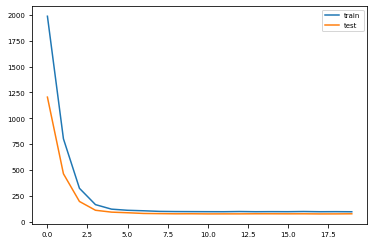

In [112]:
model = MyModel(param,channel)

In [113]:
channel = model.batch_predict(channel)

last: y_hat.shape: (45340, <class 'numpy.ndarray'>, (45340, 7))


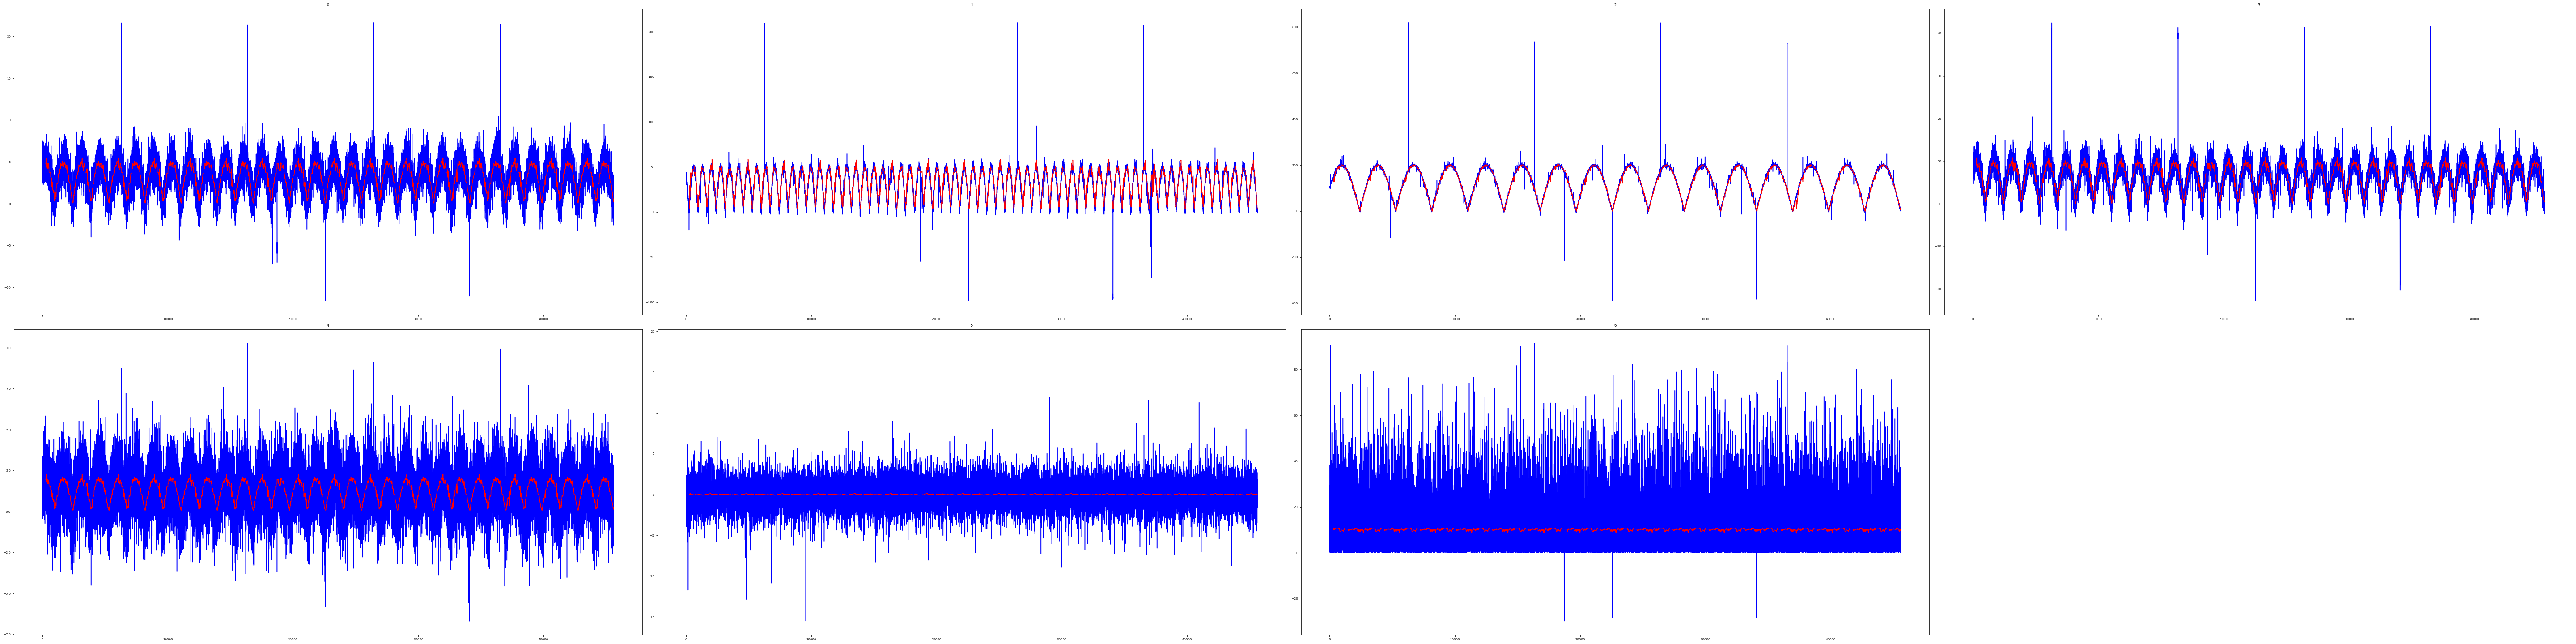

In [114]:
# seq2seq + attention + 20 epoch
raw_df = channel.test
hat_df = channel.y_hat
plot_pre_true(raw_df,hat_df)

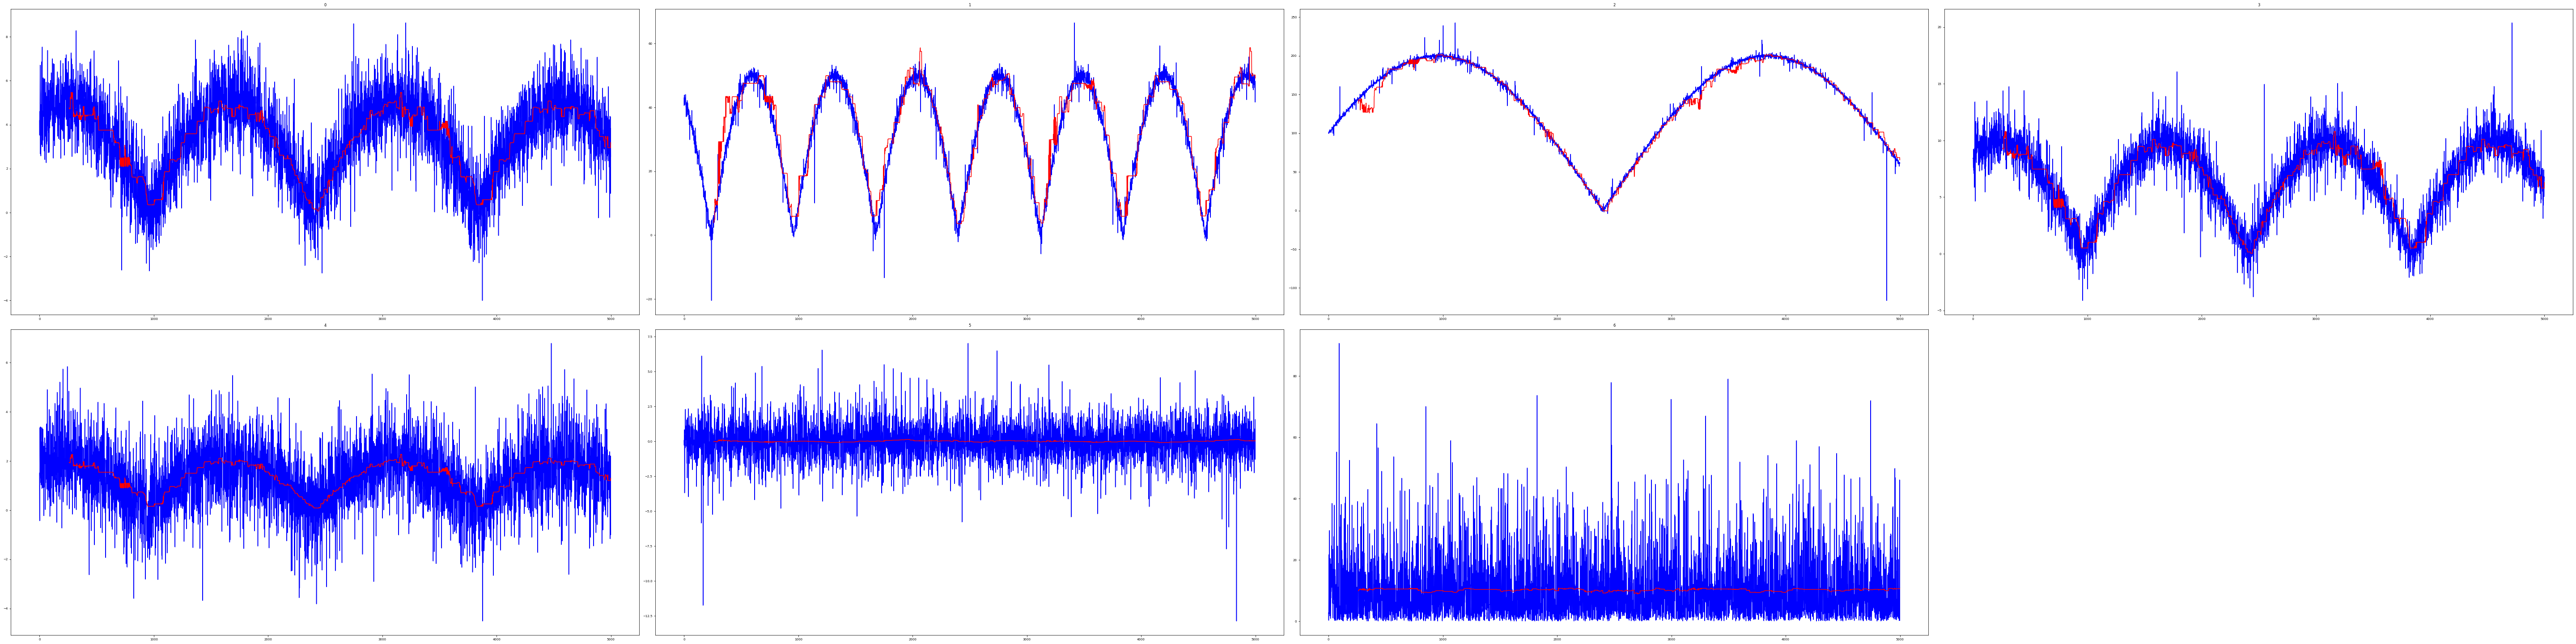

In [116]:
num = 5000
diff = raw_df.shape[0] - hat_df.shape[0]
raw = raw_df[:num,:]
d = num-diff
assert d >= 0
hat = hat_df[:d,:]
raw.shape,hat.shape
plot_pre_true(raw,hat)

## cassini data 

In [11]:
channel = Channel(param)
channel.load_data()


load datasets self.train: (132061, 26), float32
load datasets self.test: (88261, 26), float32
self.X_train: (131801, 250, 26)
self.y_train: (131801, 10, 26)
self.X_test: (88001, 250, 26)
self.y_test: (88001, 10, 26)


Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 250, 26)]    0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 80)]         0                                            
__________________________________________________________________________________________________
encoder (LSTM)                  (None, 250, 80)      34240       main_input[0][0]                 
__________________________________________________________________________________________________
repeat_vector_3 (RepeatVector)  (None, 250, 80)      0           s0[0][0]                         
                                                                 lstm_30[0][0]         

Epoch 1/20
1507/1507 [==============================] - 55s 37ms/step - loss: 0.0066 - accuracy: 0.7369 - val_loss: 0.0027 - val_accuracy: 0.8017
Epoch 2/20
1507/1507 [==============================] - 50s 33ms/step - loss: 0.0022 - accuracy: 0.8540 - val_loss: 0.0020 - val_accuracy: 0.8871
Epoch 3/20
1507/1507 [==============================] - 50s 33ms/step - loss: 0.0017 - accuracy: 0.9015 - val_loss: 0.0016 - val_accuracy: 0.9149
Epoch 4/20
1507/1507 [==============================] - 50s 33ms/step - loss: 0.0014 - accuracy: 0.9158 - val_loss: 0.0013 - val_accuracy: 0.9118
Epoch 5/20
1507/1507 [==============================] - 50s 33ms/step - loss: 0.0013 - accuracy: 0.9209 - val_loss: 0.0011 - val_accuracy: 0.9221
Epoch 6/20
1507/1507 [==============================] - 50s 33ms/step - loss: 0.0012 - accuracy: 0.9227 - val_loss: 0.0010 - val_accuracy: 0.9229
Epoch 7/20
1507/1507 [==============================] - 51s 34ms/step - loss: 0.0011 - accuracy: 0.9238 - val_loss: 0.0012 -

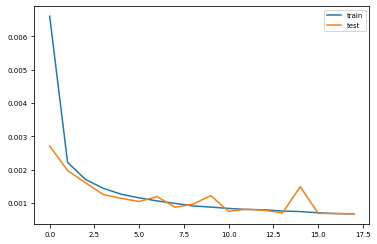

In [29]:
model = MyModel(param,channel)

In [30]:
channel = model.batch_predict(channel)

last: y_hat.shape: (88001, <class 'numpy.ndarray'>, (88001, 26))


In [21]:
def plot_pre_true(raw_df,hat_df = None,save = True):
    metric_cnt = raw_df.shape[1]
    if hat_df is not None: diff = raw_df.shape[0] - hat_df.shape[0]
    
    col_cnt = int(np.sqrt(metric_cnt)) + 2

    row_cnt = int(np.ceil(metric_cnt / col_cnt))


    # anom_flg = True if 'anom' in metric_lst else False
    anom_flg = False

    # plot metrics
    fig = plt.figure(figsize=[80, 20])
    matplotlib.rcParams.update({"font.size": 7})

    SUBPLOT_IDX = 1
    for metric_name in range(metric_cnt):
        if metric_name == 'anom':
            continaue
        ax = fig.add_subplot(row_cnt, col_cnt, SUBPLOT_IDX)
        ax.plot(raw_df[:,metric_name], color='blue')
        if hat_df is not None:
            predict = [np.nan for _ in range(diff)]
            
            predict.extend(hat_df[:,metric_name])
            ax.plot(predict, color='red')
        if anom_flg:
            val_lst = [np.nan if np.isnan(anom) else val for val, anom in
                       zip(raw_df[metric_name].values, raw_df["anom"].values)]
            ax.plot(raw_df.index, val_lst, marker='o', linestyle='dashed', color='red')

        ax.set_title(metric_name)
        SUBPLOT_IDX += 1

    fig.tight_layout()
    # plt.show()
    # file_name = f"./{file_name.replace('.npy','').replace('.csv','').replace('.txt','')}.png"
#     if save: plt.savefig('./data/%s/plot.png'%detector.id)
    plt.show()

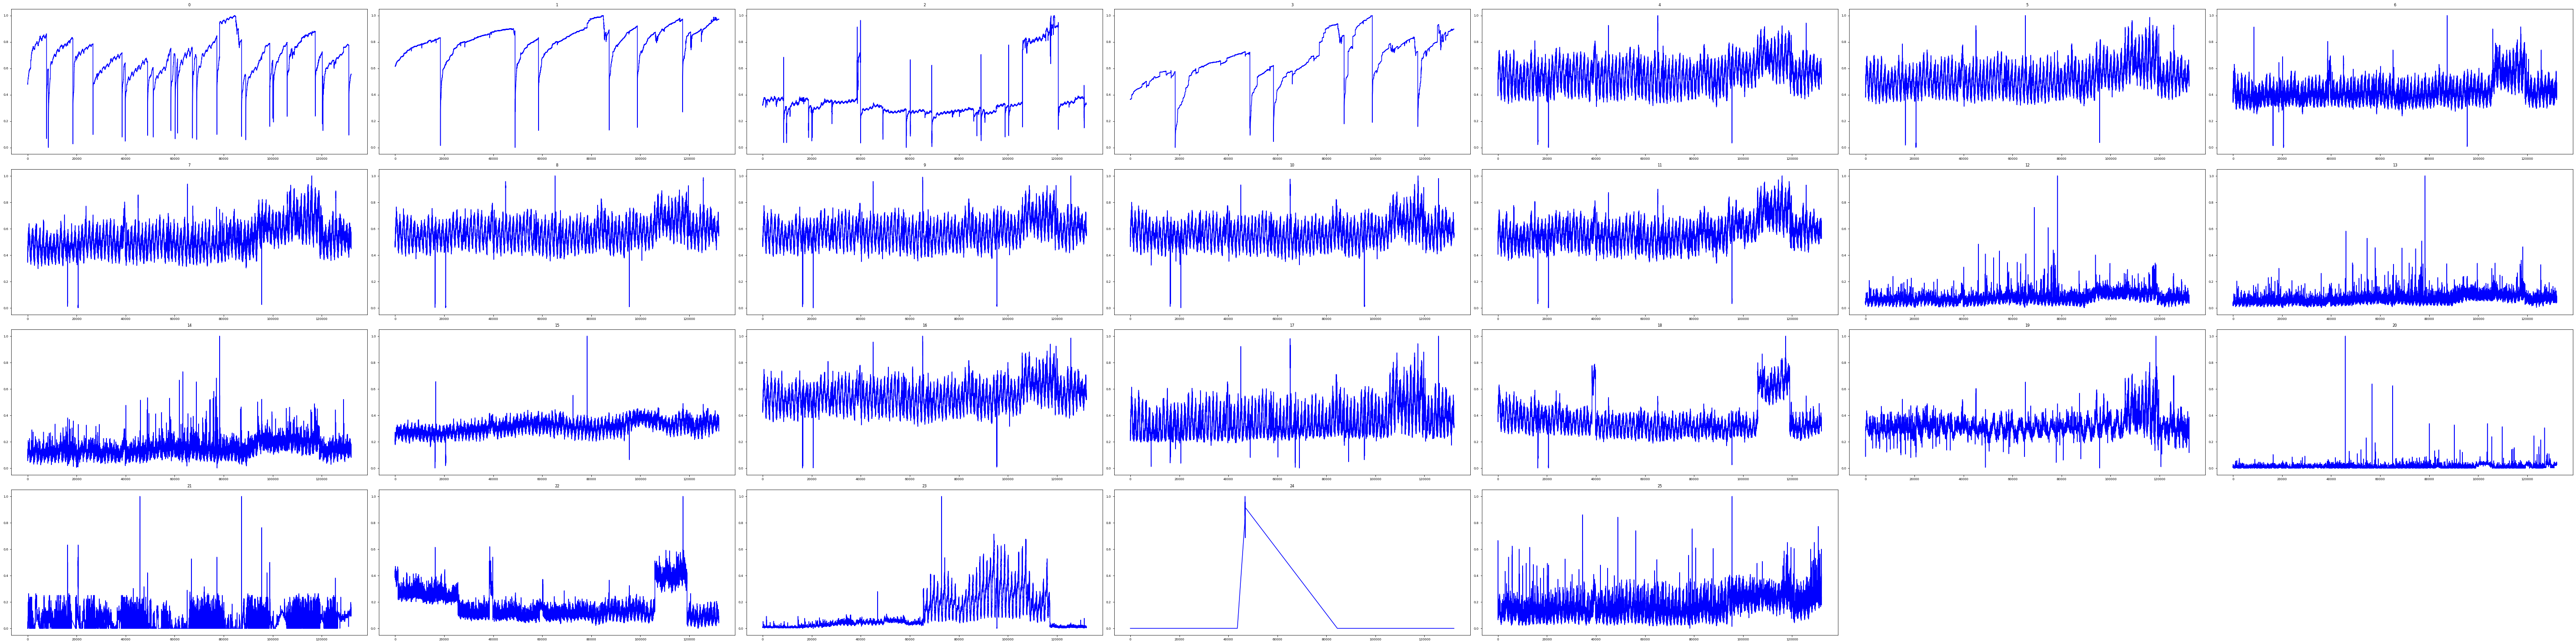

In [18]:
# complete data
train_df = channel.train
plot_pre_true(train_df)

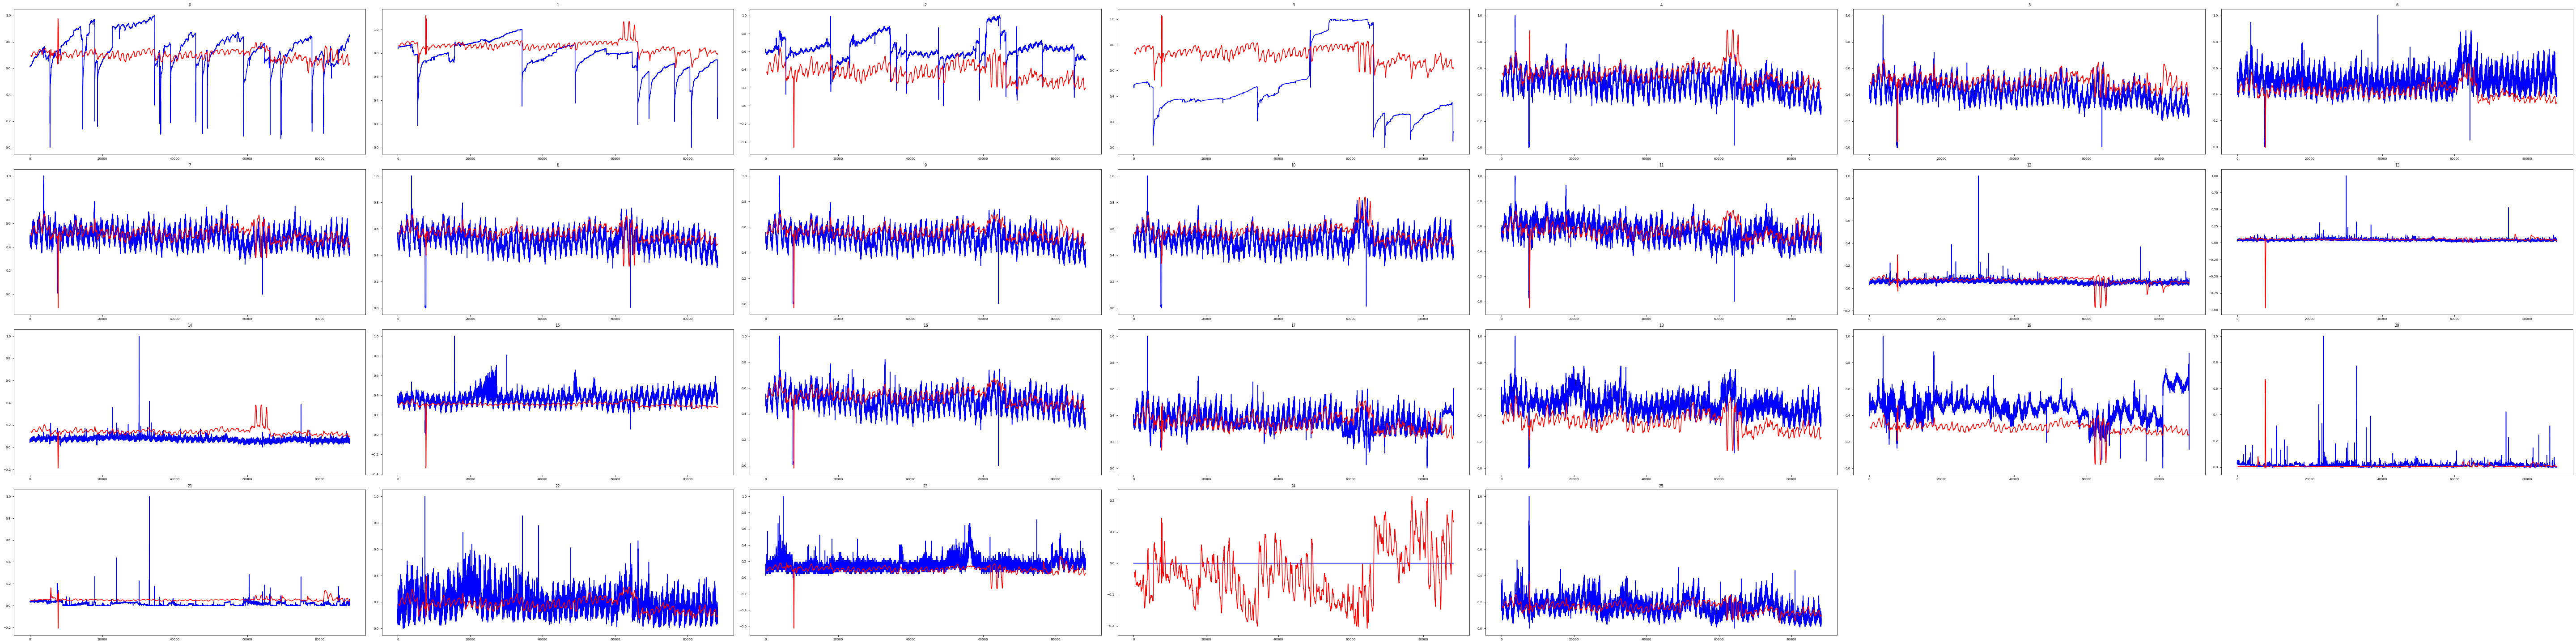

In [22]:
# seq2seq + attention + 1 epoch
raw_df = channel.test
hat_df = channel.y_hat
plot_pre_true(raw_df,hat_df)

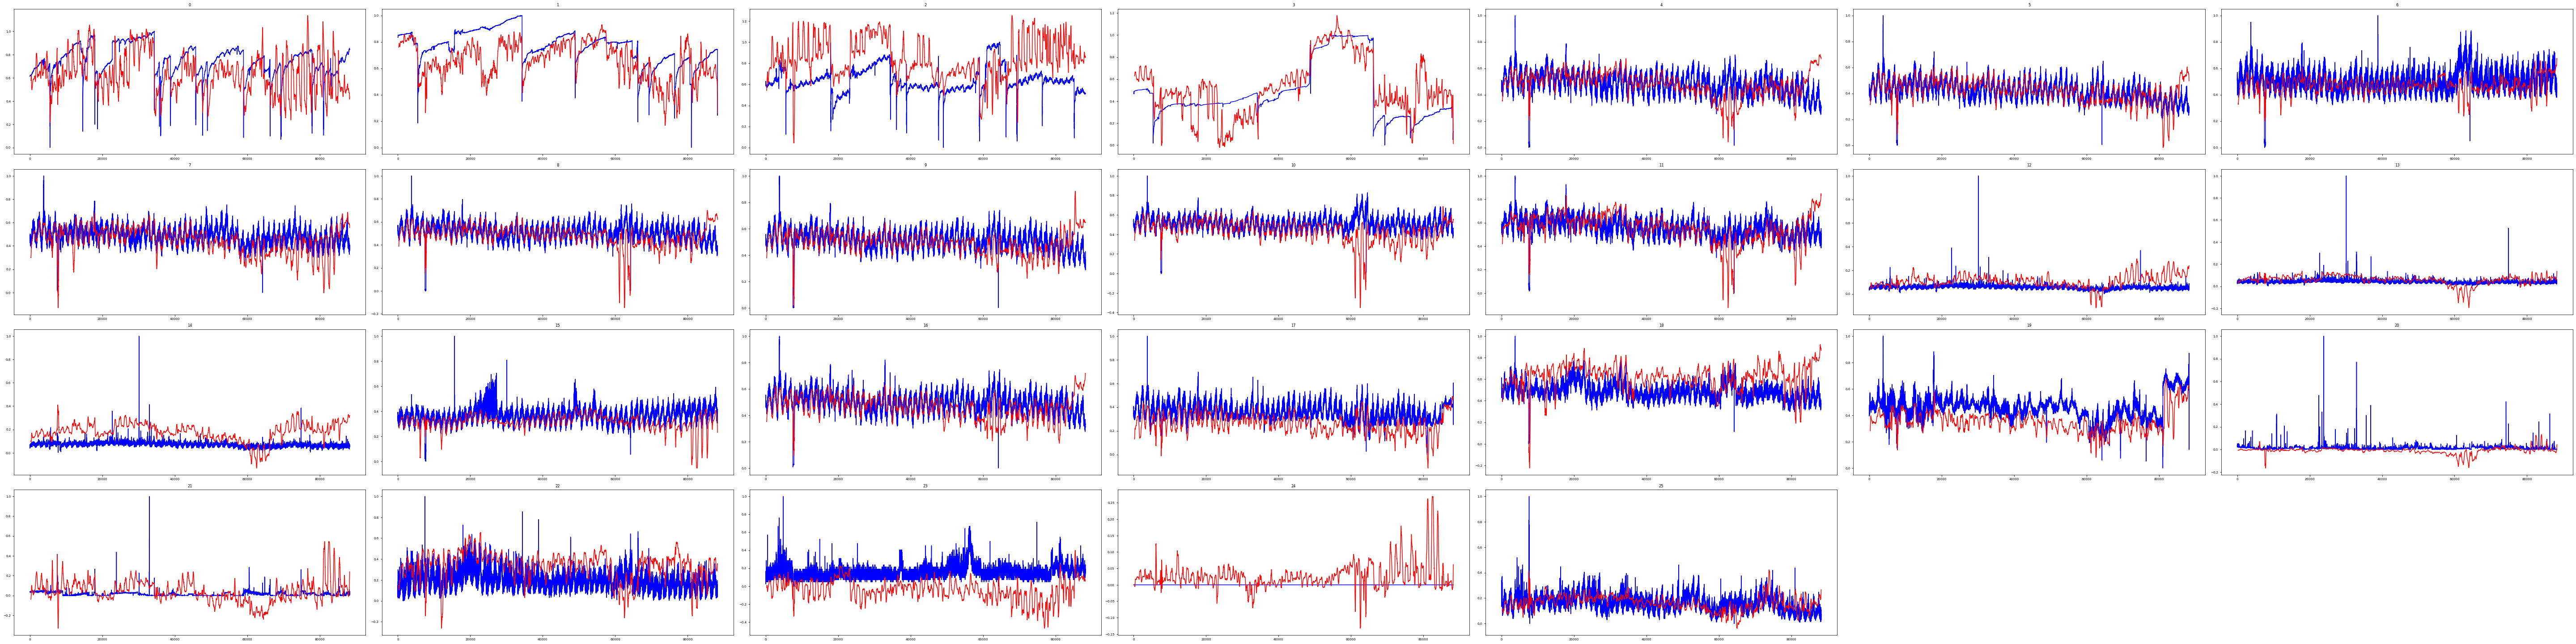

In [31]:
# seq2seq + attention + 20 epoch
raw_df = channel.test
hat_df = channel.y_hat
plot_pre_true(raw_df,hat_df)

260
9740


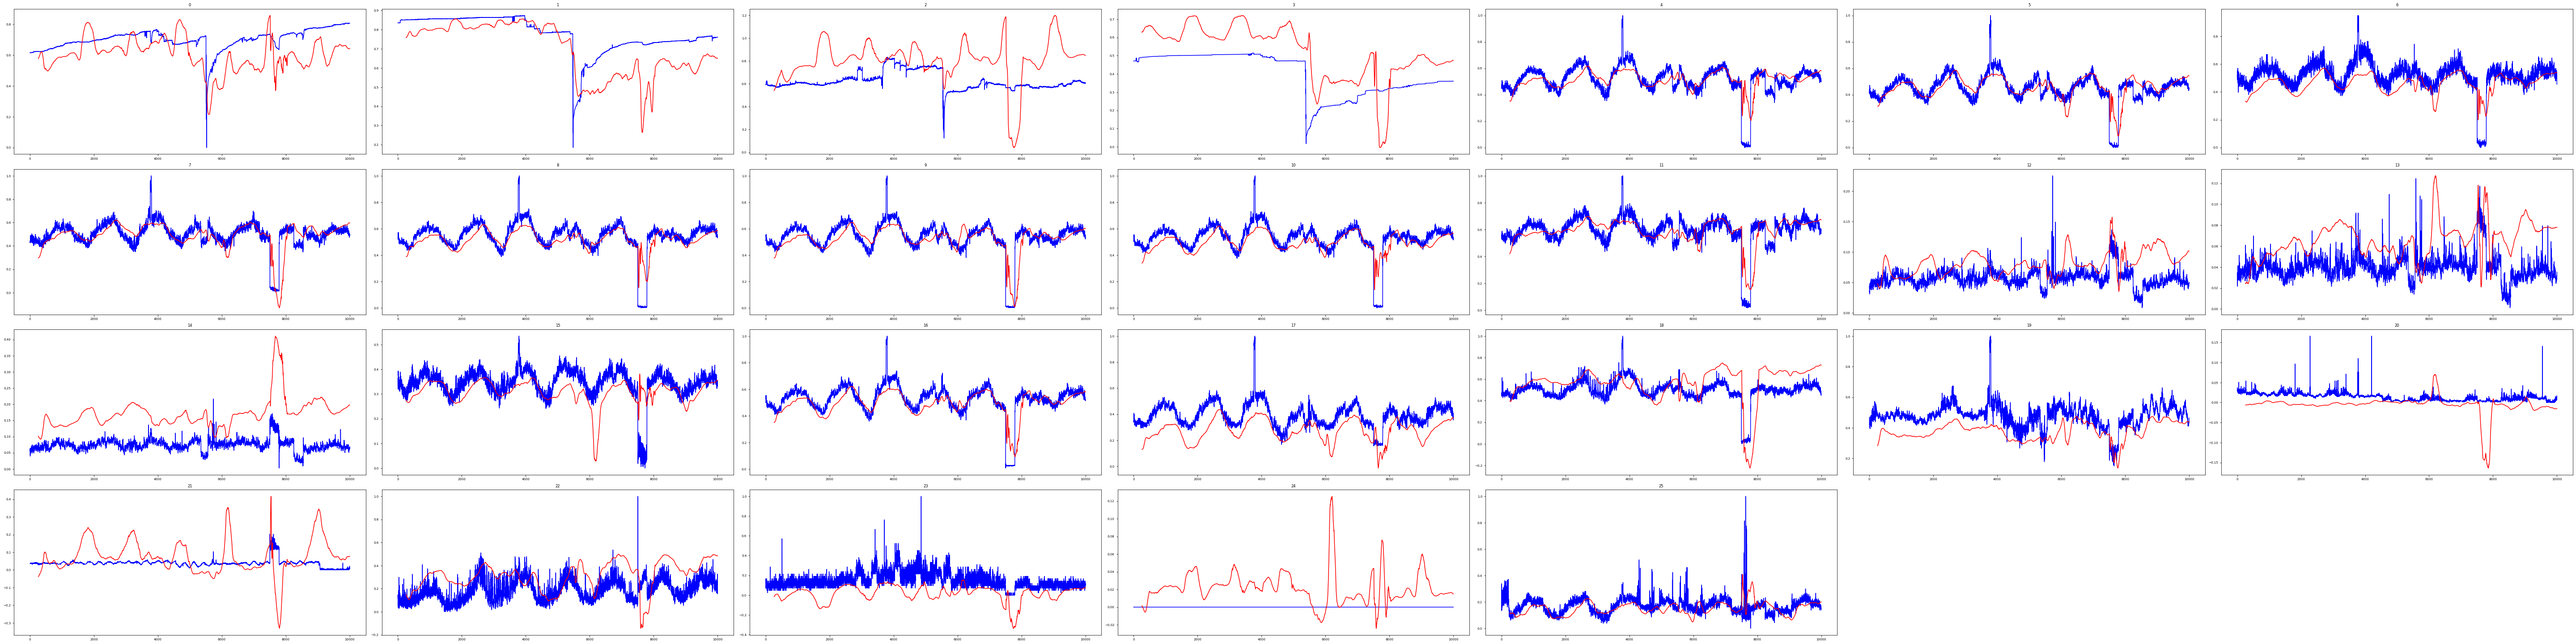

In [51]:
# detail fig
num = 10000
diff = raw_df.shape[0] - hat_df.shape[0]
raw = raw_df[:num,:]
d = num-diff
assert d >= 0
hat = hat_df[:d,:]
raw.shape,hat.shape
plot_pre_true(raw,hat)